In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 7s 22ms/step - loss: 1.8429
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 1.6972
Epoch 3/20
2/2 [==============================] - 0s 16ms/step - loss: 191.8368
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 413931692251797414804979712.0000
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: nan
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: nan
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: nan
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: nan
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: nan
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: nan
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: nan
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: nan
Epoch 13/20
2/2 [==============================] - 0s 12ms/step 

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 6ms/step


Saving figure linear_autoencoder_pca_plot


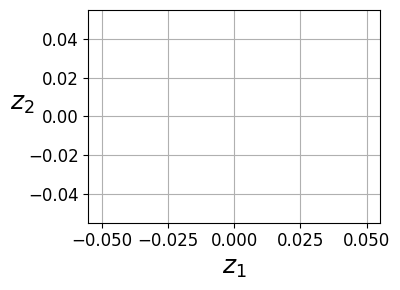

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
tf.random.set_seed(42)
np.random.seed(42)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3345 - rounded_accuracy: 0.8902 - val_loss: 0.3138 - val_rounded_accuracy: 0.9060
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3053 - rounded_accuracy: 0.9156 - val_loss: 0.3027 - val_rounded_accuracy: 0.9172
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2979 - rounded_accuracy: 0.9221 - val_loss: 0.2978 - val_rounded_accuracy: 0.9207
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2937 - rounded_accuracy: 0.9259 - val_loss: 0.2931 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2911 - rounded_accuracy: 0.9283 - val_loss: 0.2913 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2893 - rounded_accuracy: 0.9299 - val_loss: 0.2898 - val_rounded_accuracy: 0.9307
Epoch 7/20
1719/1719 [==================

1/1 [==============================] - 0s 64ms/step


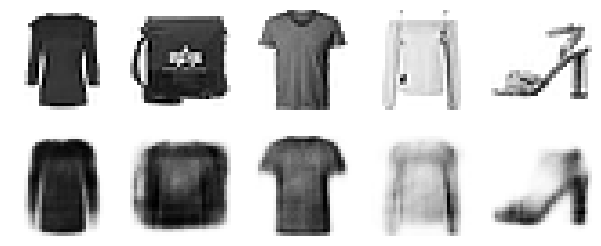

In [10]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

157/157 [==============================] - 0s 1ms/step


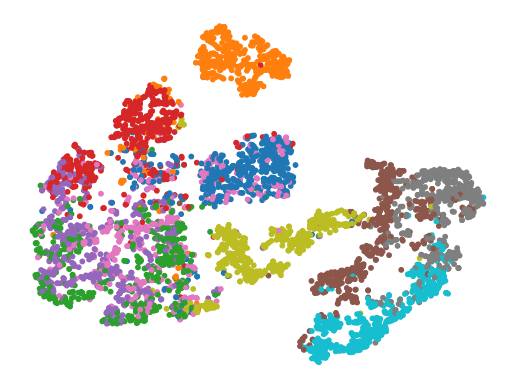

In [11]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


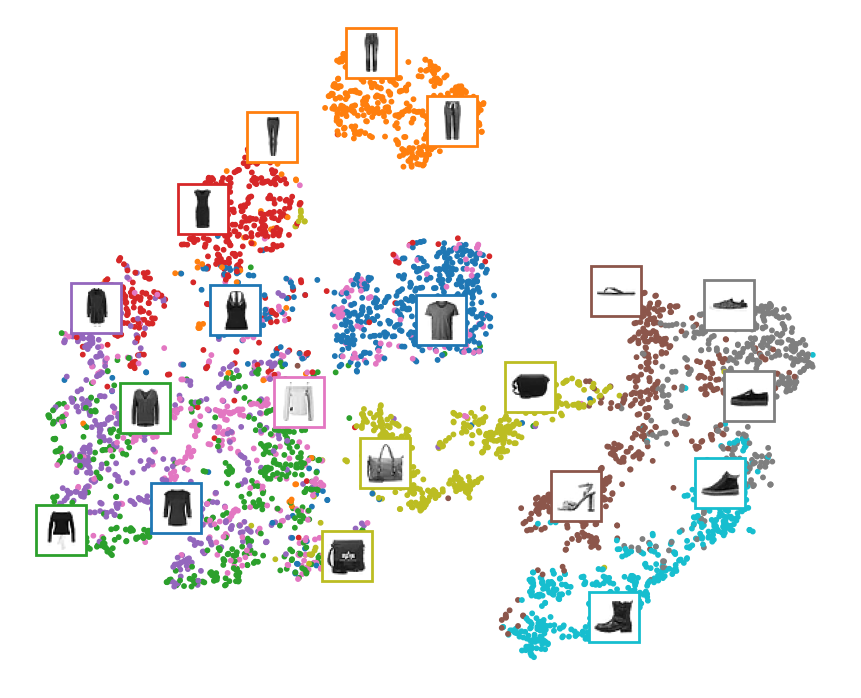

In [12]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [13]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3272 - rounded_accuracy: 0.8952 - val_loss: 0.3028 - val_rounded_accuracy: 0.9202
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9221 - val_loss: 0.2951 - val_rounded_accuracy: 0.9239
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2913 - rounded_accuracy: 0.9279 - val_loss: 0.2914 - val_rounded_accuracy: 0.9269
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2882 - rounded_accuracy: 0.9307 - val_loss: 0.2877 - val_rounded_accuracy: 0.9336
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2860 - rounded_accuracy: 0.9328 - val_loss: 0.2860 - val_rounded_accuracy: 0.9339
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2845 - rounded_accuracy: 0.9341 - val_loss: 0.2852 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

In [15]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3442 - rounded_accuracy: 0.8878 - val_loss: 0.3125 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3040 - rounded_accuracy: 0.9203 - val_loss: 0.3008 - val_rounded_accuracy: 0.9242
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2953 - rounded_accuracy: 0.9283 - val_loss: 0.2939 - val_rounded_accuracy: 0.9310
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2897 - rounded_accuracy: 0.9336 - val_loss: 0.2894 - val_rounded_accuracy: 0.9355
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9371 - val_loss: 0.2864 - val_rounded_accuracy: 0.9385
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2834 - rounded_accuracy: 0.9397 - val_loss: 0.2841 - val_rounded_accuracy: 0.9403
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 64ms/step


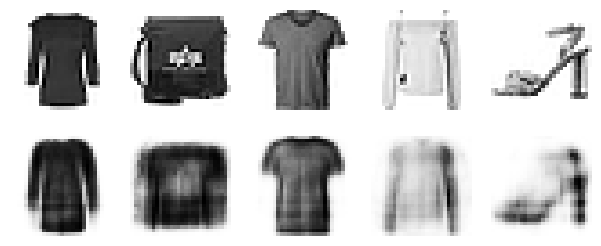

In [17]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [18]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9364 - val_loss: 0.2866 - val_rounded_accuracy: 0.9364
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2846 - rounded_accuracy: 0.9367 - val_loss: 0.2864 - val_rounded_accuracy: 0.9365
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2845 - rounded_accuracy: 0.9369 - val_loss: 0.2862 - val_rounded_accuracy: 0.9367
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2843 - rounded_accuracy: 0.9370 - val_loss: 0.2861 - val_rounded_accuracy: 0.9372
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2842 - rounded_accuracy: 0.9372 - val_loss: 0.2860 - val_rounded_accuracy: 0.9371
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2841 - rounded_accuracy: 0.9373 - val_loss: 0.2859 - val_rounded_accuracy: 0.9369
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 67ms/step


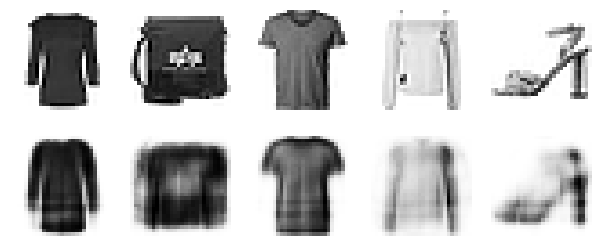

In [19]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 6ms/step - loss: 0.3009 - rounded_accuracy: 0.9198 - val_loss: 0.2832 - val_rounded_accuracy: 0.9376
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2751 - rounded_accuracy: 0.9415 - val_loss: 0.2721 - val_rounded_accuracy: 0.9468
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2704 - rounded_accuracy: 0.9464 - val_loss: 0.2706 - val_rounded_accuracy: 0.9478
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2679 - rounded_accuracy: 0.9491 - val_loss: 0.2688 - val_rounded_accuracy: 0.9488
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2661 - rounded_accuracy: 0.9510 - val_loss: 0.2667 - val_rounded_accuracy: 0.9515


In [21]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 19ms/step


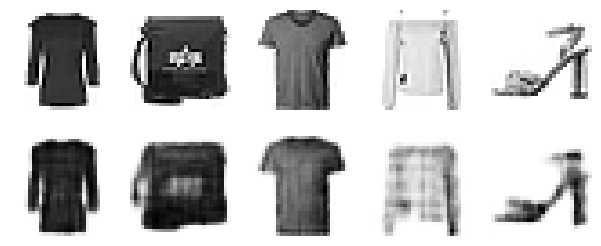

In [23]:
show_reconstructions(conv_ae)
plt.show()

In [24]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])


history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 24s 11ms/step - loss: 0.4987 - rounded_accuracy: 0.7821 - val_loss: 0.4404 - val_rounded_accuracy: 0.8215
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4023 - rounded_accuracy: 0.8417 - val_loss: 0.3770 - val_rounded_accuracy: 0.8561
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3650 - rounded_accuracy: 0.8701 - val_loss: 0.3660 - val_rounded_accuracy: 0.8725
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3535 - rounded_accuracy: 0.8796 - val_loss: 0.3504 - val_rounded_accuracy: 0.8847
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3438 - rounded_accuracy: 0.8858 - val_loss: 0.3404 - val_rounded_accuracy: 0.8888
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3358 - rounded_accuracy: 0.8906 - val_loss: 0.3338 - val_rounded_accuracy: 0.8934
Epoch 7/10
1719/1719 [=========

1/1 [==============================] - 2s 2s/step


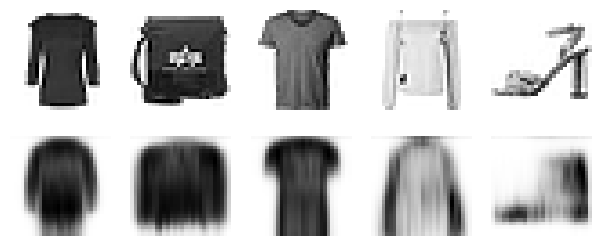

In [25]:
show_reconstructions(recurrent_ae)
plt.show()

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3457 - rounded_accuracy: 0.8812 - val_loss: 0.3189 - val_rounded_accuracy: 0.9083
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3108 - rounded_accuracy: 0.9111 - val_loss: 0.3071 - val_rounded_accuracy: 0.9181
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3041 - rounded_accuracy: 0.9168 - val_loss: 0.3022 - val_rounded_accuracy: 0.9173
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3004 - rounded_accuracy: 0.9199 - val_loss: 0.2976 - val_rounded_accuracy: 0.9244
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9221 - val_loss: 0.2958 - val_rounded_accuracy: 0.9242
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2957 - rounded_accuracy: 0.9238 - val_loss: 0.2945 - val_rounded_accuracy: 0.9289
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 158ms/step


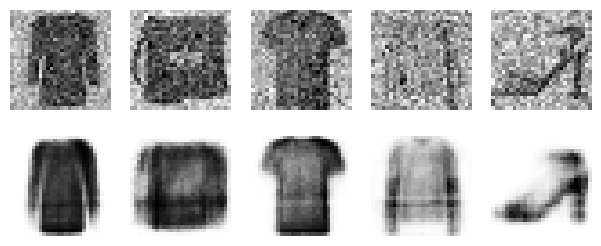

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3557 - rounded_accuracy: 0.8722 - val_loss: 0.3205 - val_rounded_accuracy: 0.9042
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3186 - rounded_accuracy: 0.9028 - val_loss: 0.3113 - val_rounded_accuracy: 0.9115
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3123 - rounded_accuracy: 0.9079 - val_loss: 0.3065 - val_rounded_accuracy: 0.9155
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3083 - rounded_accuracy: 0.9111 - val_loss: 0.3030 - val_rounded_accuracy: 0.9194
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3055 - rounded_accuracy: 0.9134 - val_loss: 0.3000 - val_rounded_accuracy: 0.9210
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3034 - rounded_accuracy: 0.9151 - val_loss: 0.2991 - val_rounded_accuracy: 0.9201
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 100ms/step
Saving figure dropout_denoising_plot


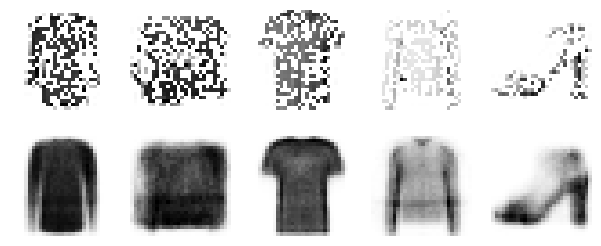

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)